<a href="https://colab.research.google.com/github/prakritipaul/mhcglobe/blob/main/v2_BERT_MHCGlobe_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Features Prediction Pipeline with Neptune Integration

1. Got BERT embeddings for 1000 training and 500 es allele/peptide_pseudosxns.
2. Has new model that integrates new "preprocessing" dense layer.

- Have an end-to-end pipeline (to be cleaned up for future)
- Has predictions of all test samples by model 3 given 1000 training and 500 es samples.
- Includes neptune integration of runs + model!
- Has informative plots!



In [1]:
!git clone https://github.com/prakritipaul/mhcglobe.git

Cloning into 'mhcglobe'...
remote: Enumerating objects: 795, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 795 (delta 144), reused 215 (delta 123), pack-reused 549
Receiving objects: 100% (795/795), 121.07 MiB | 16.67 MiB/s, done.
Resolving deltas: 100% (442/442), done.
Updating files: 100% (212/212), done.
Error downloading object: data/distB62_unique_pseudpsequences.pkl (d151a08): Smudge error: Error downloading data/distB62_unique_pseudpsequences.pkl (d151a0800777499690d258210735bbe1bf8f627fedc59b579281582b6a03b3da): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/mhcglobe/.git/lfs/logs/20240411T164121.133170002.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: data/distB62_unique_pseudpsequences.pkl: smudge filter lfs failed
You can

In [2]:
import numpy as np
import pandas as pd
import joblib as jb
import json

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.callbacks as Callbacks
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, losses

import os
import sys
sys.path.append("/content/mhcglobe/src")
import mhcglobe
import mhc_data
import inequality_loss
import train_functions as trainf
import binding_affinity as ba
import sequence_functions as seqf
import prakriti_helper_functions as phf

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install neptune
import neptune
from neptune.types import File

from google.colab import userdata

NEPTUNE_API_TOKEN = userdata.get('NEPTUNE_API_TOKEN')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.0/502.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.3 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67672 sha256=44237d22fbddaa10cb4191eb58a0bddf0bea459803fe9e5c1a4ee4043b028a66
  Stored in directory: /root/.cache/pip/wheels/42/35/4a/44ec

In [21]:
# Neptune
run = neptune.init_run(project="ppaul/MHC-BERT",
    api_token=NEPTUNE_API_TOKEN,
    tags = ["BERT", "eric model+Dense Layer Dim Reduction", "es = 500; train = 1000"],
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ppaul/MHC-BERT/e/MHCBER-34


In [17]:
# In case you have to access a previous run.

run = neptune.init_run(project="ppaul/MHC-BERT",
    api_token=NEPTUNE_API_TOKEN,
    with_id="MHCBER-6",
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ppaul/MHC-BERT/e/MHCBER-6


### Get data
Contains both BA+EL, human and non-human

In [22]:
# 729,538/1,229,838
pMHC = mhc_data.pMHC_Data(only_EL=False, drop_duplicate_records=True)
pMHC_data = pMHC.data

#### Randomly pick 100 HLA-peptide peptide + Remove them from training data
These will be the test set, and is the same number of examples as in Eric's example df.   

In [23]:
# 678024
# Note: ba = 89529 (13%), sa/ma = 588495 (87%)
human_pMHC_data = pMHC_data[pMHC_data["allele"].str.contains("HLA")]
# 12% ba's
human_pMHC_data_test = human_pMHC_data.sample(n=100, random_state=428364)

# Seeing what happens if I only have ='s
# human_pMHC_data_test = human_pMHC_data.iloc[:100]

In [24]:
# 729438
pMHC_data_train = pMHC_data[~pMHC_data.index.isin(human_pMHC_data_test.index)]

#### Reset Indices to prevent any issues downstream

In [25]:
pMHC_data_train = pMHC_data_train.reset_index(drop=True)
human_pMHC_data_test = human_pMHC_data_test.reset_index(drop=True)

In [26]:
pMHC_data_train.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-A*03:01,IEDB,=,BA,340.633333,EVMPVSMAK,HLA-A,True,True
1,HLA-A*11:01,IEDB,=,BA,17.140000,EVMPVSMAK,HLA-A,True,True
2,HLA-A*03:01,IEDB,=,BA,219.816667,KTFPPTEPK,HLA-A,True,True
3,HLA-A*11:01,IEDB,=,BA,222.213333,KTFPPTEPK,HLA-A,True,True
4,HLA-A*03:01,IEDB,=,BA,57.250000,RLYYDSMSY,HLA-A,True,True
5,HLA-A*11:01,IEDB,=,BA,237.025000,RLYYDSMSY,HLA-A,True,True
6,HLA-A*11:01,IEDB,=,BA,56.833333,AVLQSGFRK,HLA-A,True,True
7,HLA-A*03:01,IEDB,=,BA,2069.000000,KCYGVSATK,HLA-A,True,True
8,HLA-A*11:01,IEDB,=,BA,8375.750000,KCYGVSATK,HLA-A,True,True
9,HLA-A*03:01,IEDB,=,BA,188.033333,QLFKPLTKK,HLA-A,True,True


In [27]:
human_pMHC_data_test.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-A*02:06,IEDB,<,SA,100.0,RVVDYLTKL,HLA-A,True,True
1,HLA-B*27:05,IEDB,<,SA,100.0,TRYQTFVNF,HLA-B,True,True
2,HLA-A*02:12,S3_Only,>,BA,20000.0,AARHKHQVM,HLA-A,True,True
3,HLA-B*07:02,IEDB,<,SA,100.0,IPRSILMTTF,HLA-B,True,True
4,HLA-B*27:05,S3_Only,<,SA,100.0,SRVMDFFRR,HLA-B,True,True
5,HLA-C*12:02,IEDB,<,SA,100.0,STDPRPASY,HLA-C,True,True
6,HLA-B*35:03,MHCFlury2_S1,<,MA,100.0,SPHGIASVL,HLA-B,True,True
7,HLA-B*49:01,IEDB,<,SA,100.0,IEESGEHII,HLA-B,True,True
8,HLA-A*36:01,IEDB,<,SA,100.0,SLAMEMVLTGDR,HLA-A,True,True
9,HLA-B*35:07,IEDB,<,SA,100.0,MPFDFRRFDIY,HLA-B,True,True


#### Make csv's that have all columns + save in Neptune

In [28]:
# Make a csv file that can be stored in neptune
pMHC_data_train.to_csv("/content/mhcglobe/example/all_columns_pMHC_data_train_428364.csv", index=False)
human_pMHC_data_test.to_csv("/content/mhcglobe/example/all_columns_human_pMHC_data_test_428364.csv", index=False)

In [29]:
# Neptune
run["data/all_columns_training"].upload("/content/mhcglobe/example/all_columns_pMHC_data_train_428364.csv")
run["data/all_columns_testing"].upload("/content/mhcglobe/example/all_columns_human_pMHC_data_test_428364.csv")

#### Get 4 relevant columns

In [30]:
pMHC_data_train = pMHC_data_train[["allele", "peptide", "measurement_inequality", "measurement_value"]]
human_pMHC_data_test = human_pMHC_data_test[["allele", "peptide", "measurement_inequality", "measurement_value"]]

In [31]:
pMHC_data_train.head(10)

,allele,peptide,measurement_inequality,measurement_value
0,HLA-A*03:01,EVMPVSMAK,=,340.633333
1,HLA-A*11:01,EVMPVSMAK,=,17.140000
2,HLA-A*03:01,KTFPPTEPK,=,219.816667
3,HLA-A*11:01,KTFPPTEPK,=,222.213333
4,HLA-A*03:01,RLYYDSMSY,=,57.250000
5,HLA-A*11:01,RLYYDSMSY,=,237.025000
6,HLA-A*11:01,AVLQSGFRK,=,56.833333
7,HLA-A*03:01,KCYGVSATK,=,2069.000000
8,HLA-A*11:01,KCYGVSATK,=,8375.750000
9,HLA-A*03:01,QLFKPLTKK,=,188.033333


from matplotlib import pyplot as plt
_df_0['measurement_value'].plot(kind='hist', bins=20, title='measurement_value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('allele').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('peptide').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['measurement_value'].plot(kind='line', figsize=(8, 4), title='measurement_value')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['peptide'].value_counts()
    for x_label, grp in _df_4.groupby('allele')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('allele')
_ = plt.ylabel('peptide')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['allele'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='measurement_value', y='allele', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['peptide'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='measurement_value', y='peptide', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

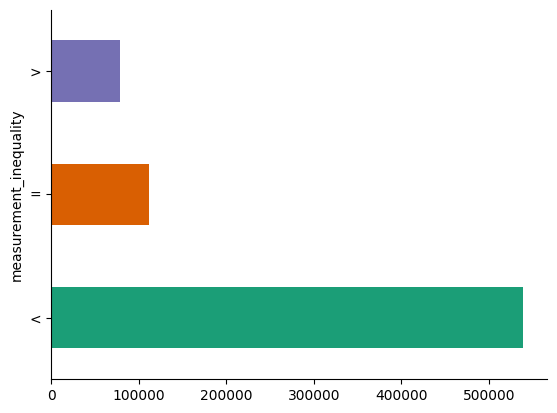

In [95]:
# @title measurement_inequality

from matplotlib import pyplot as plt
import seaborn as sns
pMHC_data_train.groupby('measurement_inequality').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

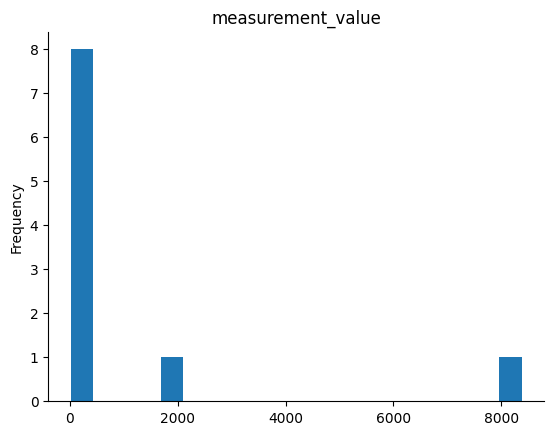

In [40]:
from matplotlib import pyplot as plt
_df_0['measurement_value'].plot(kind='hist', bins=20, title='measurement_value')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [32]:
human_pMHC_data_test.head(10)

,allele,peptide,measurement_inequality,measurement_value
0,HLA-A*02:06,RVVDYLTKL,<,100.0
1,HLA-B*27:05,TRYQTFVNF,<,100.0
2,HLA-A*02:12,AARHKHQVM,>,20000.0
3,HLA-B*07:02,IPRSILMTTF,<,100.0
4,HLA-B*27:05,SRVMDFFRR,<,100.0
5,HLA-C*12:02,STDPRPASY,<,100.0
6,HLA-B*35:03,SPHGIASVL,<,100.0
7,HLA-B*49:01,IEESGEHII,<,100.0
8,HLA-A*36:01,SLAMEMVLTGDR,<,100.0
9,HLA-B*35:07,MPFDFRRFDIY,<,100.0


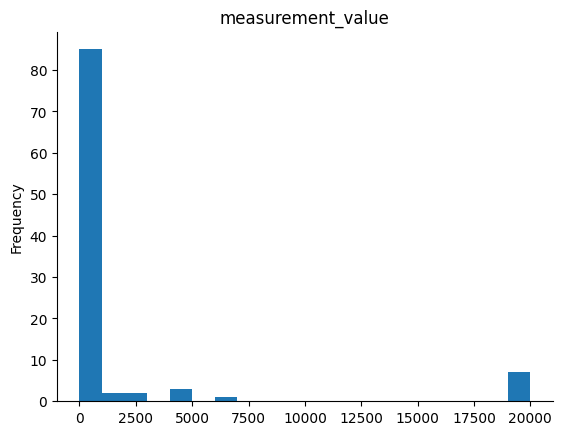

In [47]:
# @title measurement_value

from matplotlib import pyplot as plt
human_pMHC_data_test['measurement_value'].plot(kind='hist', bins=20, title='measurement_value')
plt.gca().spines[['top', 'right',]].set_visible(False)

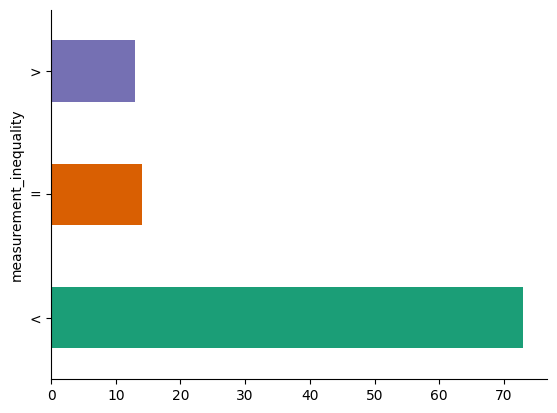

In [46]:
# @title measurement_inequality

from matplotlib import pyplot as plt
import seaborn as sns
human_pMHC_data_test.groupby('measurement_inequality').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Balance the dataset to get X_tr, Y_tr, X_es, Y_es!


In [33]:
# Returns a data frame with cols
# test (is it es or not), allele, peptide, measurement_inequality, measurement_value
train, es = trainf.BalanceSplitData().get_train_val(pMHC_data_train)

# reset indices to prevent downstream issues
# 583650
train = train.reset_index(drop=True)
# 145788
es = es.reset_index(drop=True)

#### Save these!

In [34]:
train_csv_name = "/content/mhcglobe/example/train_428364_24_04_11_BERT.csv"
es_csv_name = "/content/mhcglobe/example/es_428364_24_04_11_BERT.csv"
# es_csv_name = "/content/mhcglobe/example/es_428364_24_04_05_es_1000.csv"

In [35]:
train.to_csv(train_csv_name, index=False)
es.to_csv(es_csv_name, index=False)

In [36]:
# Neptune
run["data/train_428364_24_04_11_BERT"].upload(train_csv_name)
run["data/es_428364_24_04_11_BERT"].upload(es_csv_name)
# run["data/es_428364_24_04_05_es_1000"].upload(es_csv_name)

### REMOVE THIS LATER: just a test!

In [37]:
train, es = train.iloc[:1000], es.iloc[:500]

In [38]:
train

,test,allele,peptide,measurement_inequality,measurement_value
0,False,H-2-Kd,GFKDGNEYI,=,2.65000
1,False,H-2-Kd,GWKDGNEYI,=,4.50000
2,False,H-2-Kd,AYLVSIFLHL,=,6020.00000
3,False,H-2-Kd,EFCDMLRL,>,5000.00000
4,False,H-2-Kd,GYCLTKWMI,=,69.85000
...,...,...,...,...,...
995,False,H-2-Kd,TWNPHKMMGVP,>,5000.00000
996,False,H-2-Kd,TWQRTRALV,=,10000.00000
997,False,H-2-Kd,TYCHSCDSTF,=,6250.00000
998,False,H-2-Kd,TYCKEKDI,=,2904.67034


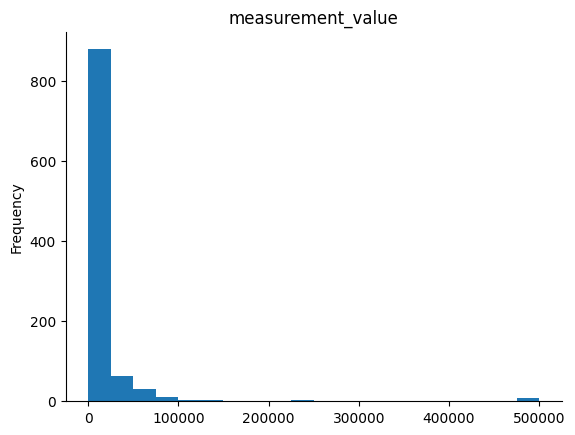

In [45]:
# @title measurement_value

from matplotlib import pyplot as plt
train['measurement_value'].plot(kind='hist', bins=20, title='measurement_value')
plt.gca().spines[['top', 'right',]].set_visible(False)

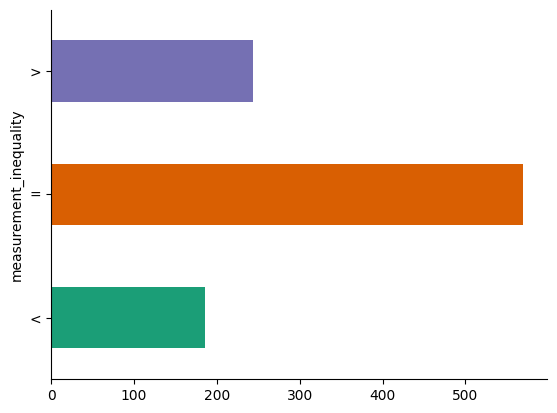

In [44]:
# @title measurement_inequality

from matplotlib import pyplot as plt
import seaborn as sns
train.groupby('measurement_inequality').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [39]:
es

,test,allele,peptide,measurement_inequality,measurement_value
0,True,H-2-Kd,KYNPMKTHI,=,1.9
1,True,H-2-Kd,LFKTTVNSL,=,300.0
2,True,H-2-Kd,LYTVKYPNL,>,7500.0
3,True,H-2-Kd,RGPGRAFVTI,=,30500.0
4,True,H-2-Kd,SYVPSAEQIL,=,280.0
...,...,...,...,...,...
495,True,HLA-B*27:04,GRFGQDFSTF,<,100.0
496,True,HLA-B*27:04,GRFGYLEGQEY,<,100.0
497,True,HLA-B*27:04,GRFITVMKF,<,100.0
498,True,HLA-B*27:04,GRFKDVLVLL,<,100.0


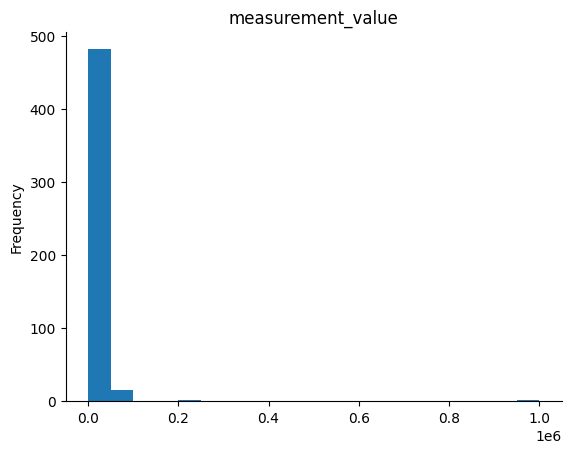

In [49]:
# @title measurement_value

from matplotlib import pyplot as plt
es['measurement_value'].plot(kind='hist', bins=20, title='measurement_value')
plt.gca().spines[['top', 'right',]].set_visible(False)

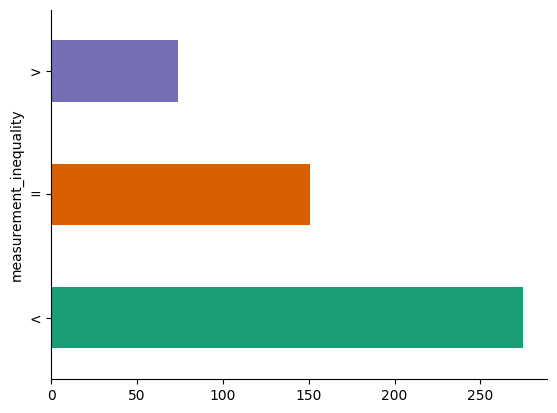

In [48]:
# @title measurement_inequality

from matplotlib import pyplot as plt
import seaborn as sns
es.groupby('measurement_inequality').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Get MHC pseudosxns (X1_train, X1_es)- should be a function
Returns a list.

In [50]:
def get_allele_pseudoseqs(train_or_es, mhc_data):
  """
    Gets pseudosquences for MHC alleles present in a train or es dataframe.

    Args:
      train_or_es: Data frame with cols
        test (is it es or not), allele, peptide, measurement_inequality, measurement_value

      mhc data object: used to make allele2seq dict.
        e.g. pMHC = mhc_data.pMHC_Data
        {'HLA-A*02:560': 'YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYEWY'...}

    Returns:
      allele_pseudoseqs: list of shape (n_alleles, 34)
"
    Example:
      'DLA-88*508:01', 'Mamu-B*08:01' -> 'YYATYGEKVETVYVDTLYITYRDYTWAVWNYTWY',
                                         'YSSEYEERAGHTDADTLYLTYHYYTWAEVAYTWY'
  """
  mhc_alleles = train_or_es["allele"]
  allele2seq_dict = mhc_data.allele2seq

  allele_pseudoseqs = [str(allele2seq_dict[a]) for a in mhc_alleles]
  return allele_pseudoseqs

In [51]:
# X1_train, X1_es
training_allele_pseudoseqs = get_allele_pseudoseqs(train, pMHC)
es_allele_pseudoseqs = get_allele_pseudoseqs(es, pMHC)

### Get MHCFlurry representations of peptides (X2_train, X2_es)
Returns a list.

Basically change "seq_to_15mer" function to just get the amino acids of the representation.

In [52]:
def get_mhcflurry_representation(peptide):
  """
    Given a peptide sequence, return the mhcflurry representation.

    Examples:
      Example 1: ARDV (4) -> ARDV-X7-ARDV
	    Example 2: ARDVA (5) -> ARDV-X7-RDVA
      Example 3: ARDVAA (6) -> ARDV-X7-DVAA
        (X7 padding is true until len(peptide) = 8)
      Example 4: ARDVAAAAA (9) -> ARDV-XXX-A-XXX-AAAA
      Example 5: ARDVAAAAAA (10) -> ARDV-XXX-AA-XX-AAAA
  """
  middle_AAs = peptide[4:-4]
  num_X = 15-(len(middle_AAs)+8)

  if num_X%2 == 0:
    pad_len = num_X//2
    middle_AAs_with_pad = "X"*pad_len + middle_AAs + "X"*pad_len

  else:
    pad_len_left = num_X//2 + 1
    pad_len_right = pad_len_left - 1
    middle_AAs_with_pad = "X"*pad_len_left + middle_AAs + "X"*pad_len_right

  mhcflurry_representation = peptide[:4] + middle_AAs_with_pad + peptide[-4:]
  return mhcflurry_representation

In [53]:
def get_peptide_pseudoseqs(train_or_es):
  """
    Same function as "get_allele_pseudoseqs", but for peptides.

    Returns:
      peptide_pseudoseqs:
        list of shape (n_peptides, 15)
  """
  peptides = train_or_es["peptide"]
  peptide_pseudoseqs = [get_mhcflurry_representation(p) for p in peptides]
  return peptide_pseudoseqs

In [54]:
# X2_train, X2_es
training_peptide_pseudoseqs = get_peptide_pseudoseqs(train)
es_peptide_pseudoseqs = get_peptide_pseudoseqs(es)

### Get BERT representation of both MHC and peptides (X1_train', X1_es', X2_train', X2_es')
https://github.com/facebookresearch/esm/issues/348

FUTURE IMPROVEMENT:
Add a functionality where the attention mask is 0 wherever there's an X in the AA sxn (peptide).

In [55]:
def get_BERT_embeddings(aa_sxns, tokenizer, model, return_tensors):
  """
    Gets features of alleles or peptides from a BERT-like model, like ESM2.

    Args:
      aa_sxns: list of amino acid sequences.
        e.g. training/es_allele_pseudoseqs, training_peptide/es_pseudoseqs

      tokenizer: tokenizer for the model from huggingface.
      model: model for the model from huggingface.
      return_tensors: "tf" or "pt"

    Returns:
      PyTorch/Tensorflow tensors of shape n_alleles/peptides x 34/15 x n_embedding_dims
        e.g. n_embedding_dims = 320 for ESM2_t6_8M_UR50D.
        Note: embeddings are from the last hidden state of the model.

    Example:
      tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
      model = TFEsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
      get_BERT_embeddings(training_allele_pseudoseqs, tokenizer, model, "tf")
  """
  inputs = tokenizer(aa_sxns, return_tensors=return_tensors, padding=False, truncation=False)
  input_ids = inputs["input_ids"]
  attention_mask = inputs["attention_mask"]
  # Update them to not have <cls> and <eos> tokens.
  updated_input_ids = input_ids[:, 1:-1]
  updated_attention_mask = attention_mask[:, 1:-1]
  updated_inputs = {"input_ids": updated_input_ids, "attention_mask": updated_attention_mask}
  # Get outputs
  outputs = model(**updated_inputs)
  # Get last_hidden_states
  BERT_embeddings = outputs.last_hidden_state
  return BERT_embeddings

#### TF version

In [81]:
# from transformers import EsmTokenizer, EsmModel
from transformers import EsmTokenizer, TFEsmModel
import torch

tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
# model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = TFEsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFEsmModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'esm.embeddings.position_ids']
- This IS expected if you are initializing TFEsmModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFEsmModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFEsmModel were not initialized from the PyTorch model and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
# Neptune
run["BERT/model"] = "facebook/esm2_t6_8M_UR50D"

In [58]:
# Neptune
run["BERT/num_training_samples"] = len(training_allele_pseudoseqs)
run["BERT/num_es_samples"] = len(es_allele_pseudoseqs)

In [59]:
# for test: 5000, 34, 320
training_allele_BERT_embeddings = get_BERT_embeddings(training_allele_pseudoseqs, tokenizer, model, "tf")
# for test: 5000, 15, 320
training_peptide_BERT_embeddings = get_BERT_embeddings(training_peptide_pseudoseqs, tokenizer, model, "tf")

In [60]:
es_allele_BERT_embeddings = get_BERT_embeddings(es_allele_pseudoseqs, tokenizer, model, "tf")
es_peptide_BERT_embeddings = get_BERT_embeddings(es_peptide_pseudoseqs, tokenizer, model, "tf")

#### PT version

In [24]:
from transformers import EsmTokenizer, EsmModel
import torch

pt_tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
pt_model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
pt_training_allele_BERT_embeddings = get_BERT_embeddings(training_allele_pseudoseqs, pt_tokenizer, pt_model, "pt")
pt_training_peptide_BERT_embeddings = get_BERT_embeddings(training_peptide_pseudoseqs, pt_tokenizer, pt_model, "pt")

In [ ]:
pt_training_allele_BERT_embeddings

### Get Y from get_XY function

In [61]:
Y_tr = seqf.get_XY(train, encode_type='ONE_HOT', get_Y=True)[1]
Y_es = seqf.get_XY(es, encode_type='ONE_HOT', get_Y=True)[1]

### Make new model with dense layer

In [62]:
# This path doesn't matter because it never gets used.
new_mhcglobe_path = "/content/mhcglobe/example/"
init_ensemble = mhcglobe.ensemble(train_type='init', new_mhcglobe_path=new_mhcglobe_path)

model_3 = init_ensemble.ensemble_base_models[2]

#### Let's look at it!

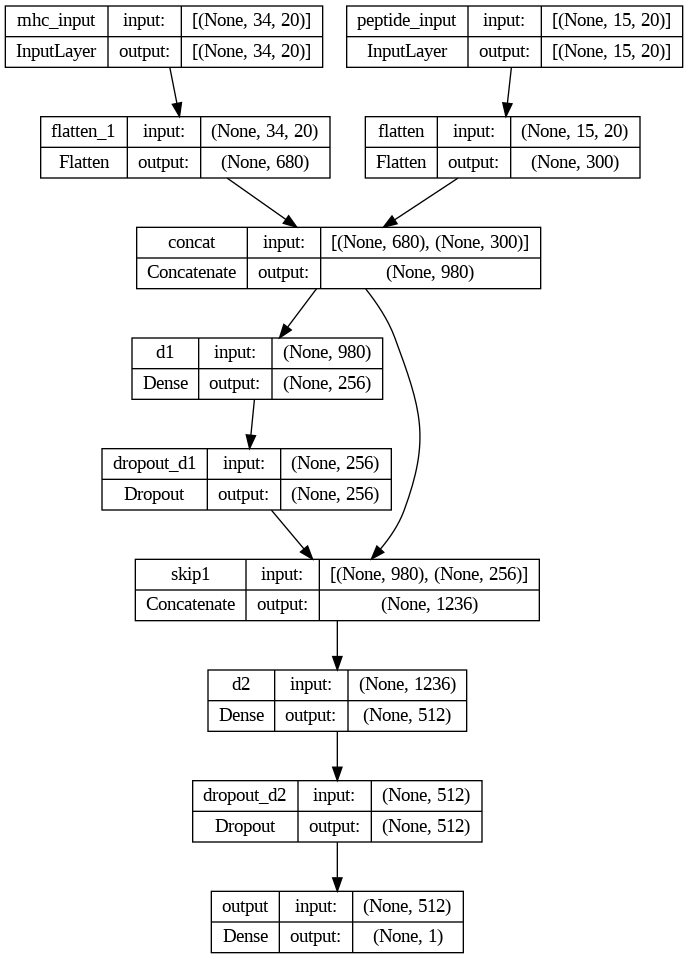

In [82]:
from tensorflow.keras.utils import plot_model
plot_model(model_3, to_file='model.png', show_shapes=True, show_layer_names=True)

In [64]:
# Neptune
run["model/model_tf_graph"].upload("/content/model.png")

In [209]:
# Neptune
run["model/eric_model_dir"] = model_dir

In [65]:
# Define input tensors
BERT_allele = Input(shape=(34, 320))
peptide_allele = Input(shape=(15, 320))

# Dimensionality reduction layers
reduced_allele = Dense(20, kernel_regularizer = tf.keras.regularizers.l1(l=0.01), activation='relu')(BERT_allele)
reduced_peptide = Dense(20, kernel_regularizer = tf.keras.regularizers.l1(l=0.01), activation='relu')(peptide_allele)

# Assume model takes two inputs: [reduced_input_1, reduced_input_2]
# Adjusted to reshape if necessary and connect to model
output_1 = model([reduced_allele, reduced_peptide])

# Define the new comprehensive model
new_model = Model(inputs=[BERT_allele, peptide_allele], outputs=output_1)

In [66]:
# Neptune
BERT_architecture = {"embedding_layer": "last",
                     "layers": "2 Dense- separate dim reduction",
                     "kernel_regularizer": "l1(l=0.01)",
                     "activation": "relu",
                     "inputs": "BERT_allele (30, 320); peptide_allele (15, 320)",
                     "output": "model on dim reduction of BERT features = 20 dims"}

run["BERT/BERT_architecture"] = BERT_architecture

### Compilation related

In [67]:
# Neptune
# model 1
# model_optimizer_params = {"learning_rate": 0.0011339304,
#                             "momentum": 0.5,
#                             "epsilon": 6.848580326162904e-07,
#                             "centered": True,
#                             "optimizer_type": "RMSprop"}

model_3_optimizer_params = {"optimizer_type": "RMSprop",
                            "learning_rate": 0.0019147476,
                            "momentum": 0.5,
                            "epsilon": 3.17051703095139e-07,
                            "centered": True}

run["model/optimizer_params"] = model_3_optimizer_params

In [68]:
model_optimizer_params = model_3_optimizer_params

optimizer = optimizers.RMSprop(
    learning_rate=model_optimizer_params["learning_rate"],
    momentum=model_optimizer_params["momentum"],
    epsilon=model_optimizer_params["epsilon"],
    centered=model_optimizer_params["centered"])

### Make root mean squared

In [69]:
# Neptune
model_compiler_params = {"optimizer": "RMSprop",
                           "loss": "inequality_loss.MSEWithInequalities().loss",
                           "metrics": ["mean_absolute_error", "mean_squared_error", "root_mean_squared_error"]}

# Converts list into correct format.
model_compiler_params["metrics"] = json.dumps(model_compiler_params["metrics"])
run["model/compiler_params"] = model_compiler_params

### Compile the model
Code is not ideal

In [70]:
new_model.compile(optimizer=optimizer, loss=inequality_loss.MSEWithInequalities().loss, metrics=["mean_absolute_error", "mean_squared_error", phf.root_mean_squared_error])

### Check what this `new_model` is like!


In [71]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 34, 320)]            0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 15, 320)]            0         []                            
                                                                                                  
 dense (Dense)               (None, 34, 20)               6420      ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 15, 20)               6420      ['input_2[0][0]']             
                                                                                              

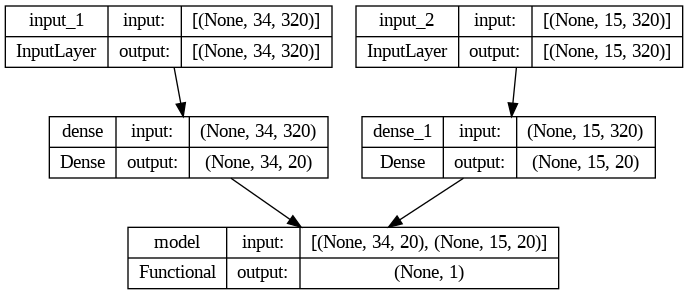

In [72]:
from tensorflow.keras.utils import plot_model
plot_model(new_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [73]:
# Neptune
from neptune.types import File
run["model/tf_graph"].upload("/content/model.png")

### Train the model

In [74]:
# Neptune
training_specs = {"batch_size": 100,
                  "epochs": 300,
                  "shuffle": True,
                  "verbose": 1,
                  "mhc_callbacks": ["monitor=val_loss", "patience=20", "mode=min", "baseline=1", "min_delta=0.0001"],
                  "early_stopping": True,
                  "num_training_samples": 1000,
                  "num_es_samples": 500}

# Converts list into correct format.
training_specs["mhc_callbacks"] = json.dumps(training_specs["mhc_callbacks"])

# Neptune
run["training/training_specs"] = training_specs

In [75]:
mhcglobe_callbacks = [Callbacks.EarlyStopping(
                monitor='val_loss',
                patience=20,
                mode='min',
                baseline=1,
                min_delta=0.0001)]

### Training!

In [76]:
verbose = 1
history = new_model.fit([training_allele_BERT_embeddings, training_peptide_BERT_embeddings], Y_tr,
                        batch_size= training_specs["batch_size"], #hparams['batch_size'], 10000
                        epochs=training_specs["epochs"],
                        validation_data=([es_allele_BERT_embeddings, es_peptide_BERT_embeddings], Y_es),
                        shuffle=True,
                        verbose=verbose,
                        callbacks=mhcglobe_callbacks)

Epoch 1/300
10/10 [==============================] - 3s 43ms/step - loss: 5.1780 - mean_absolute_error: 0.2620 - mean_squared_error: 0.1166 - root_mean_squared_error: 0.3169 - val_loss: 1.7787 - val_mean_absolute_error: 0.1993 - val_mean_squared_error: 0.0510 - val_root_mean_squared_error: 0.2218
Epoch 2/300
10/10 [==============================] - 0s 11ms/step - loss: 0.7205 - mean_absolute_error: 0.1825 - mean_squared_error: 0.0537 - root_mean_squared_error: 0.2308 - val_loss: 0.2242 - val_mean_absolute_error: 0.1760 - val_mean_squared_error: 0.0440 - val_root_mean_squared_error: 0.2019
Epoch 3/300
10/10 [==============================] - 0s 11ms/step - loss: 0.2041 - mean_absolute_error: 0.1876 - mean_squared_error: 0.0559 - root_mean_squared_error: 0.2359 - val_loss: 0.1833 - val_mean_absolute_error: 0.1989 - val_mean_squared_error: 0.0505 - val_root_mean_squared_error: 0.2205
Epoch 4/300
10/10 [==============================] - 0s 11ms/step - loss: 0.1895 - mean_absolute_error: 0.

### Save with Neptune!

In [77]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

In [78]:
for i in range(len(loss)):
    run["training/loss"].append(loss[i])
    run["training/val_loss"].append(val_loss[i])
    run["training/mae"].append(mae[i])
    run["training/val_mae"].append(val_mae[i])
    run["training/mse"].append(mse[i])
    run["training/val_mse"].append(val_mse[i])
    run["training/rmse"].append(rmse[i])
    run["training/val_rmse"].append(val_rmse[i])

### Predict using this model!!!

In [83]:
test_allele_pseudoseqs = get_allele_pseudoseqs(human_pMHC_data_test, pMHC)
test_peptide_pseudoseqs = get_peptide_pseudoseqs(human_pMHC_data_test)

# 100, 34, 320
test_allele_BERT_embeddings = get_BERT_embeddings(test_allele_pseudoseqs, tokenizer, model, "tf")
test_peptide_BERT_embeddings = get_BERT_embeddings(test_peptide_pseudoseqs, tokenizer, model, "tf")

In [84]:
# Only has mhcglobe scores.
test_predictions = new_model.predict([test_allele_BERT_embeddings, test_peptide_BERT_embeddings])

4/4 [==============================] - 0s 3ms/step


In [85]:
mhcglobe_scores = new_model.predict([test_allele_BERT_embeddings, test_peptide_BERT_embeddings])

# Get them
mhcglobe_scores = mhcglobe_scores.flatten()
mhcglobe_affinities = list(map(ba.to_ic50, mhcglobe_scores))

prediction_dict = {"mhcglobe_affinities": mhcglobe_affinities, "mhcglobe_scores": mhcglobe_scores}
prediction_df = pd.DataFrame(prediction_dict)

# Munge to_predict so I can correctly concatenate the columns
munged_to_predict = human_pMHC_data_test
munged_to_predict.index = prediction_df.index

# Present the data nicely!
prediction_df_all = pd.concat([munged_to_predict, prediction_df], axis=1)

4/4 [==============================] - 0s 3ms/step


In [86]:
prediction_df_all

,allele,peptide,measurement_inequality,measurement_value,mhcglobe_affinities,mhcglobe_scores
0,HLA-A*02:06,RVVDYLTKL,<,100.0,1440.466719,0.327831
1,HLA-B*27:05,TRYQTFVNF,<,100.0,1443.780911,0.327618
2,HLA-A*02:12,AARHKHQVM,>,20000.0,1438.926846,0.327930
3,HLA-B*07:02,IPRSILMTTF,<,100.0,1444.931752,0.327545
4,HLA-B*27:05,SRVMDFFRR,<,100.0,1449.973447,0.327223
...,...,...,...,...,...,...
95,HLA-C*15:02,RIHDIAVQL,=,196.0,1435.975662,0.328119
96,HLA-A*11:01,ALERLLSLKK,=,822.0,1446.616120,0.327437
97,HLA-B*27:09,HRVSQDGLNL,<,100.0,1443.084610,0.327663
98,HLA-B*57:03,SSSALVSSLHL,<,100.0,1445.821477,0.327488


### Save the predictions

In [ ]:
run["testing/test_predictions_428364_24_04_11_BERT"].upload(File.as_pickle(test_predictions))
run["testing/test_predictions_df_all_24_04_11_BERT"].upload(File.as_pickle(prediction_df_all))

In [ ]:
run["testing/test_predictions_df_all_viz_428364_24_04_11_BERT"].upload(File.as_html(prediction_df_all))

### Get Scatter Plot + r^2/MSE

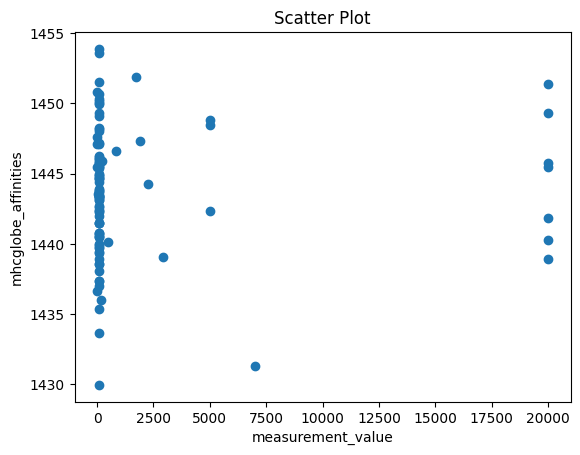

In [92]:
import matplotlib.pyplot as plt

savefig_name = "scatter_plot_BERT_model3_train1000_es500_24_04_11.png"

plt.scatter(prediction_df_all["measurement_value"], prediction_df["mhcglobe_affinities"])
plt.xlabel("measurement_value")
plt.ylabel("mhcglobe_affinities")
plt.title("Scatter Plot")
plt.savefig(savefig_name)

In [93]:
predictions_r, predictions_mse = phf.get_r_squared_mse(prediction_df_all, "measurement_value", "mhcglobe_affinities")
print("R-squared:", predictions_r)
print("MSE:", predictions_mse)

R-squared: 0.0018629009947347792
MSE: 26341904.25520109


In [94]:
# Neptune
run["testing/r_squared"] = predictions_r
run["testing/mse"] = predictions_mse
run["testing/scatter_plot"].upload((savefig_name))

### Set Up Model
Here, I'm accessing a previous model

In [232]:
model_object = neptune.init_model(project="ppaul/MHC-BERT",
                                  api_token=NEPTUNE_API_TOKEN,
                                  with_id="MHCBER-BERT240405"
)

ModelNotFound: No existing Model was found at ppaul/MHC-BERT/MHCBER-BERT240405es1000.

### Make a version

In [234]:
model_version = neptune.init_model_version(project="ppaul/MHC-BERT",
    api_token=NEPTUNE_API_TOKEN,
    model="MHCBER-BERT240405",
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ppaul/MHC-BERT/m/MHCBER-BERT240405/v/MHCBER-BERT240405-1


In [235]:
# model_object["run_id"] = run["sys/id"].fetch()
model_version["run_id"] = run["sys/id"].fetch()

In [236]:
# model_object["num_training_samples"] = len(training_allele_BERT_embeddings)
# model_object["num_es_samples"] = len(es_allele_BERT_embeddings)

model_version["num_training_samples"] = len(training_allele_BERT_embeddings)
model_version["num_es_samples"] = len(es_allele_BERT_embeddings)

In [237]:
# model_object["BERT_architecture"] = BERT_architecture
# model_object["BERT_architecture/model"] = "ESM2_t6_8M_UR50D"

model_version["BERT_architecture"] = BERT_architecture
model_version["BERT_architecture/model"] = "ESM2_t6_8M_UR50D"

In [238]:
# model_object["model/model_tf_graph"].upload("/content/model.png")
# model_object["model/new_model_tf_graph"].upload("/content/model.png")

model_version["model/model_tf_graph"].upload("/content/model.png")
model_version["model/new_model_tf_graph"].upload("/content/model.png")

In [239]:
# model_object["optimizer_params"] = model_optimizer_params
model_version["optimizer_params"] = model_optimizer_params

In [240]:
# model_object["compiler_params"] = model_compiler_params
model_version["compiler_params"] = model_compiler_params

In [1]:
run.stop()
model.stop()

NameError: name 'run' is not defined